# 0- Fit the tree ring center

Author: Johnny Esteves, University Of Michigan

### Description
In this notebook, you'll measure the tree ring center fit on super flat field images for the R02 S02 (ITL) and R22 S11 (e2v) sensors.



In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import fitsio as fits

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()


import numpy as np

from scipy.stats import binned_statistic_2d, binned_statistic
from skimage.measure import block_reduce
from skimage.util import view_as_blocks
from scipy.ndimage.filters import gaussian_filter
import scipy.optimize as opt

In [2]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(obj=None, ax=None, size="5%", pad=0.1):
    should_restore = False

    if obj is not None:
        ax = obj.axes
    elif ax is None:
        ax = plt.gca()
        should_restore = True

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)

    plt.colorbar(obj, cax=cax)

    if should_restore:
        plt.sca(ax)
        
def imshow(image, qq=[0.5,97.5], show_colorbar=True, **kwargs):
    vmin1,vmax1 = np.percentile(image[np.isfinite(image)], qq)
    if 'vmin' not in kwargs.keys():
        kwargs['vmin'] = vmin1
    if 'vmax' not in kwargs.keys():
        kwargs['vmax'] = vmax1
    plt.imshow(image, **kwargs)
    if show_colorbar:
        colorbar()

In [3]:
# 
import numpy
import scipy

def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] does not evenly divide array shape[1].'
    shape = np.array((A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape).astype(int)
    strides = np.array((block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides).astype(int)
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

def zero_by_region(data, region_shape, num_sigmas_clip=4.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks   = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                region_data[~region_mask] = clipped_data
                
    return levels, mask
def get_diff_lowpass(image, size=250, power=4.0, use_zero=True, geometry=(2,8)):
    if use_zero:
        image1 = image.copy()
        levels,mask = zero_by_region(image1, (image1.shape[0]/geometry[0], image1.shape[1]/geometry[1]))

        return image1/image
    else:
        diff = apply_filter(image, size, power=power)
    
        return diff/image

# Load Data


### Super Flat Files

Voltage=0

In [4]:
import numpy as np
import lsst.eotest.image_utils as imutils
import lsst.afw.image as afwImage
from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd

def make_ccd_mosaic(infile, bias_frame=None, gains=None, fit_order=1,dm_view=False):
    """Combine amplifier image arrays into a single mosaic CCD image array."""
    ccd = MaskedCCD(infile, bias_frame=bias_frame)
    datasec = parse_geom_kwd(ccd.amp_geom[1]['DATASEC'])
    nx_segments = 8
    ny_segments = 2
    nx = nx_segments*(datasec['xmax'] - datasec['xmin'] + 1)
    ny = ny_segments*(datasec['ymax'] - datasec['ymin'] + 1)
    mosaic = np.zeros((ny, nx), dtype=np.float32) # this array has [0,0] in the upper right corner on LCA-13381 view o
     
    for ypos in range(ny_segments):
        for xpos in range(nx_segments):
            amp = ypos*nx_segments + xpos + 1      
            detsec = parse_geom_kwd(ccd.amp_geom[amp]['DETSEC'])
            xmin = nx - max(detsec['xmin'], detsec['xmax'])
            xmax = nx - min(detsec['xmin'], detsec['xmax']) + 1
            ymin = ny - max(detsec['ymin'], detsec['ymax'])
            ymax = ny - min(detsec['ymin'], detsec['ymax']) + 1
            #
            # Extract bias-subtracted image for this segment - overscan not corrected, since we don't pass overscan he
            #
            segment_image = ccd.unbiased_and_trimmed_image(amp, fit_order=fit_order)
            subarr = segment_image.getImage().getArray()
            #
            # Determine flips in x- and y- direction
            #
            if detsec['xmax'] > detsec['xmin']: # flip in x-direction
              subarr = subarr[:, ::-1]
            if detsec['ymax'] > detsec['ymin']: # flip in y-direction
              subarr = subarr[::-1, :]
            #
            # Convert from ADU to e-
            #
            if gains is not None:
              subarr *= gains[amp]
            #
            # Set sub-array to the mosaiced image
            #
            mosaic[ymin:ymax, xmin:xmax] = subarr  
    if dm_view:
      # transpose and rotate by -90 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower') rotated CW by 90 for DM view
      mosaicprime = np.zeros((ny, nx), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=-1)    
      image = afwImage.ImageF(mosaicprime)  
    else:
      # transpose and rotate by 180 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower')
      mosaicprime = np.zeros((nx, ny), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=2)    
      image = afwImage.ImageF(mosaicprime)  
    
    return image
      

In [5]:
# from astropy.io import fits
# def get_fits(fname):
#     hdulist = fits.open(fname)
#     image = hdulist[1].data
#     return image,hdulist

# def load_image(fname,sensor='itl',overwrite=False):
#     if (os.path.isfile('tmp/%s_flat.fits'%(sensor))) & (not overwrite):
#         fname = 'tmp/%s_flat.fits'%(sensor)
#         print('tmp: found flat field')
#         print(fname)
#         image, hdulist = get_fits(fname)
#     else:
#         image, hdulist = get_fits(fname)
#         image = image#-np.median(image)
#         ## save the file locally
#         hdulist[1].data = image
#         hdulist.writeto('tmp/%s_flat.fits'%sensor,overwrite=True)
#     return image, hdulist

# ITL Tree Ring Center

In [6]:
sensor='itl'

In [7]:
path= '/gpfs/slac/lsst/fs3/g/data/rawData/focal-plane/20200825/MC_C_20200825_000060/MC_C_20200825_000060_%s.fits'
flat= path%('R22_S11')

In [8]:
image = np.rot90(make_ccd_mosaic(flat).getArray())

In [9]:
image = np.rot90(make_ccd_mosaic(flat).getArray())

## row flipped
# image = np.flip(image,0)

In [10]:
## Checking image shape: (4000, 4072)

image.shape

(4004, 4096)

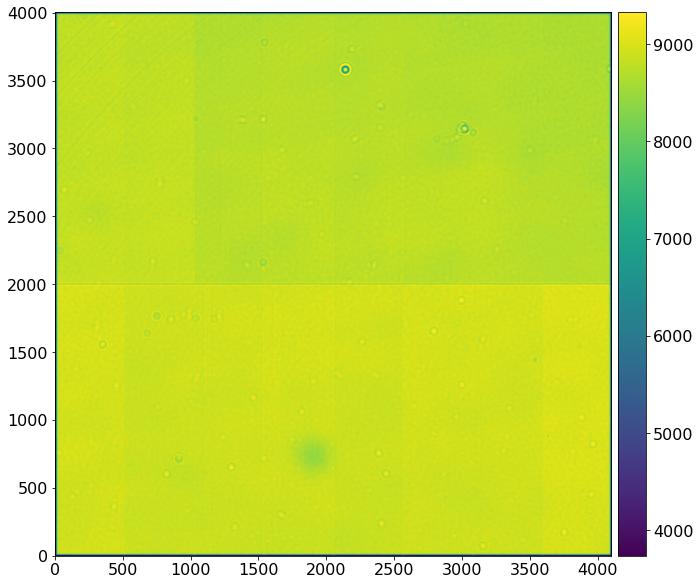

In [11]:
imshow(image)

### High Pass Filter

<ipython-input-3-16399c5acec6>:88: RuntimeWarning: divide by zero encountered in true_divide
  return image1/image


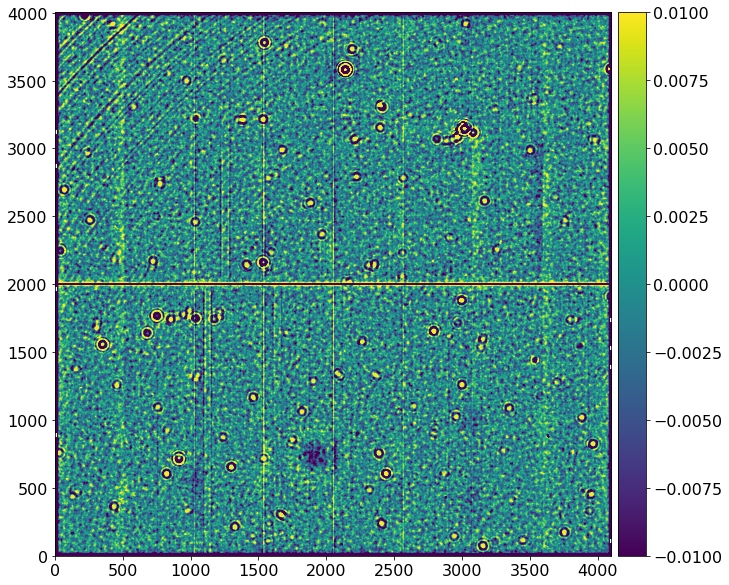

In [12]:
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
imshow(diff, interpolation='bicubic',vmin=-0.01,vmax=0.01)
# plt.title('%s, detector %s' % (ref.run, ref.dataId['detector']))

In [13]:
# sensor = 'itl'
# hdu[1].data = diff
# hdu.writeto('tmp/%s_flat_diff.fits'%(sensor),overwrite=True)

In [14]:
np.nanstd(diff.flatten())

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_16/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0-ext/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


nan

## Pre-processing: smooth and masking

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

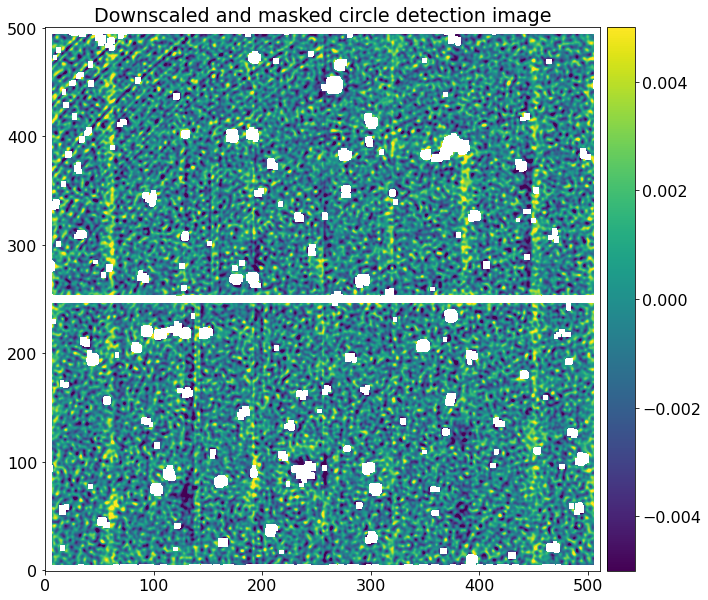

In [17]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.009 # For stronger rings
#threshold = 0.003 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask , (downscale, downscale), func=np.nanmax)
diff2[mask2] = np.nan

imshow(diff2, interpolation='bicubic', vmin=-0.005, vmax=0.005)#
plt.title('Downscaled and masked circle detection image')

### Finding the TR Center

In [18]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.percentile(r,75), np.max(r), 1.0))
    #v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.mean(r), np.max(r), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

In [19]:
xlow, xhig = -800., 0.
ylow, yhig = 4000., 4800.

xlow, xhig = 4000., 4800.
ylow, yhig = -800., 0.

cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]], popsize=40)
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.0013075196453968445
 message: 'Optimization terminated successfully.'
    nfev: 723
     nit: 8
 success: True
       x: array([567.08545082, -68.91610868])

Original scale coordinates: 4536.68, -551.33


In [72]:
## x0,y0 = -335.49, 4095.84
## std=0.00017528

### Diagnostic Plots

(-601.3288694071417, 4200.0)

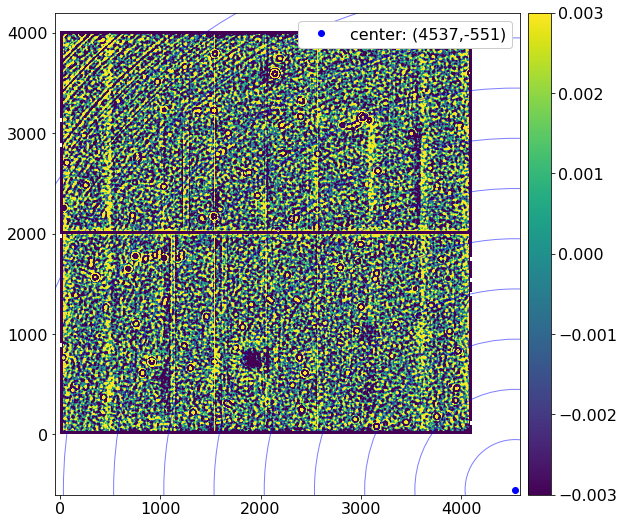

In [20]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, vmin=-0.003, vmax=0.003)
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 6000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

plt.xlim(-50,x0+50)
plt.ylim(-50+y0,4200)

# plt.xlim(x0-50,4000)
# plt.ylim(0., y0+50)

# plt.xlim(x0-50,4000)
# plt.ylim(y0-50, 4000.)

# plt.show()

# plt.title(itl2)


(500.0, 6660.733245616486)

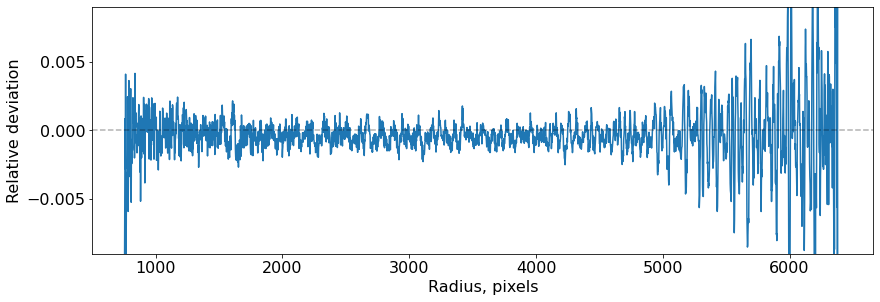

In [21]:
pos,v = fn_measure(x0, y0, mask=mask, step=2.0, statistic='mean')

plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.009, 0.009)
plt.xlim(500,)

Will analyse the following radial interval: 1879 - 6154 pixels


<ipython-input-22-eae5b6438655>:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


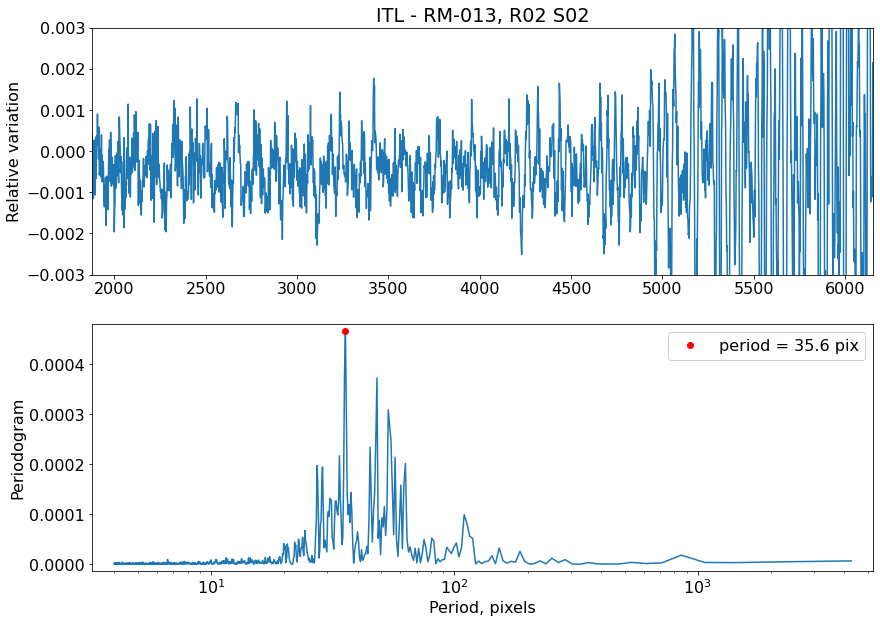

In [22]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylim(-0.003,0.003)
plt.ylabel('Relative variation')
plt.title('ITL - RM-013, R02 S02')

#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

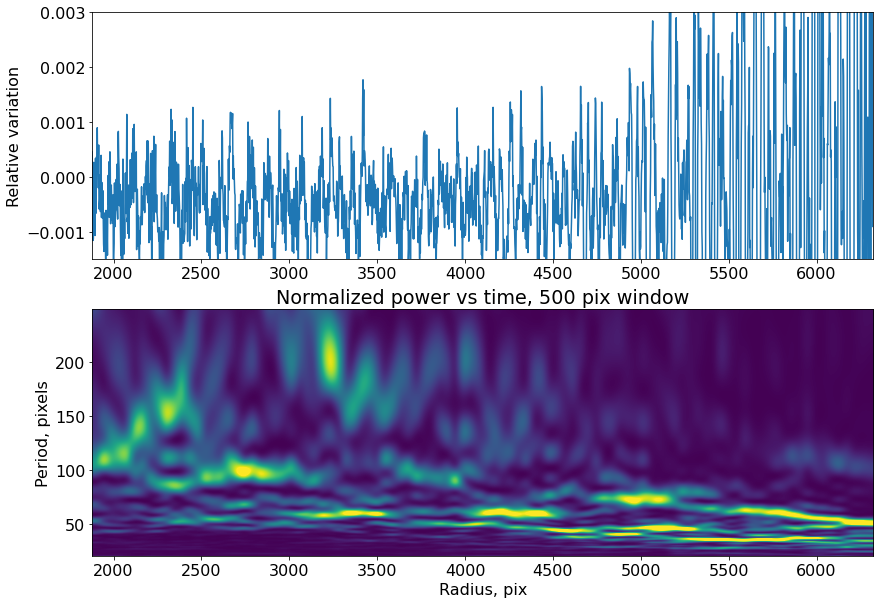

In [23]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


<ipython-input-24-deb69ba41938>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


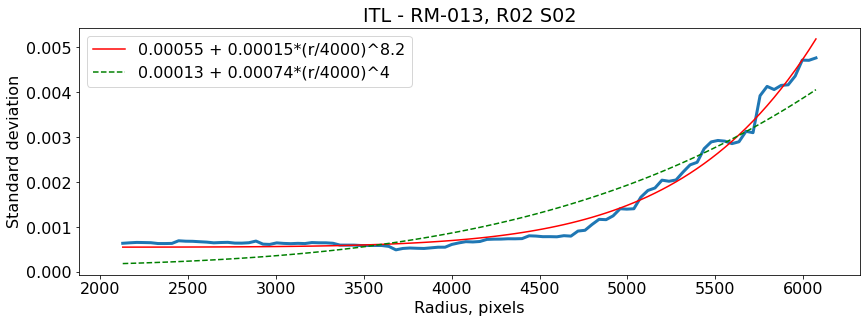

In [24]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title('ITL - RM-013, R02 S02')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)

# E2V Tree Ring Center

In [33]:
image, hdu = load_image(path+etv2,sensor='e2v',overwrite=True)

## row flipped
image = np.flip(image,0)

In [34]:
## Checking image shape: (4004, 4096)

image.shape

(4004, 4096)

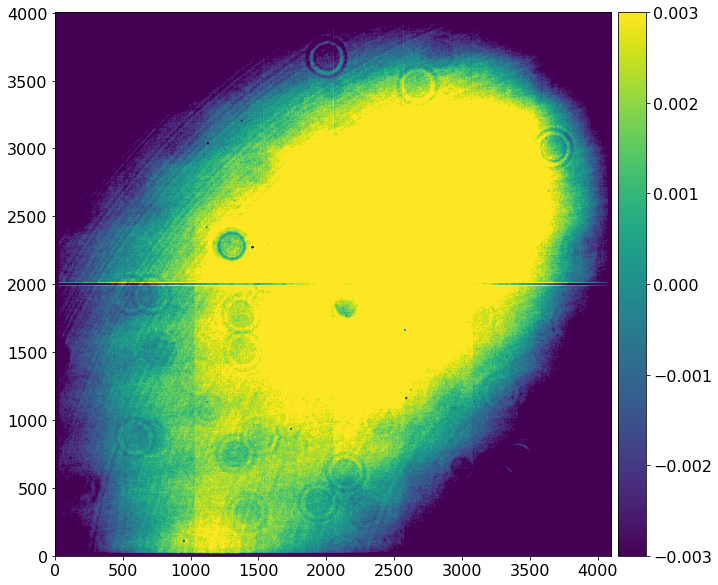

In [36]:
imshow(image-np.median(image),vmin=-0.003,vmax=0.003)

### High Pass Filter

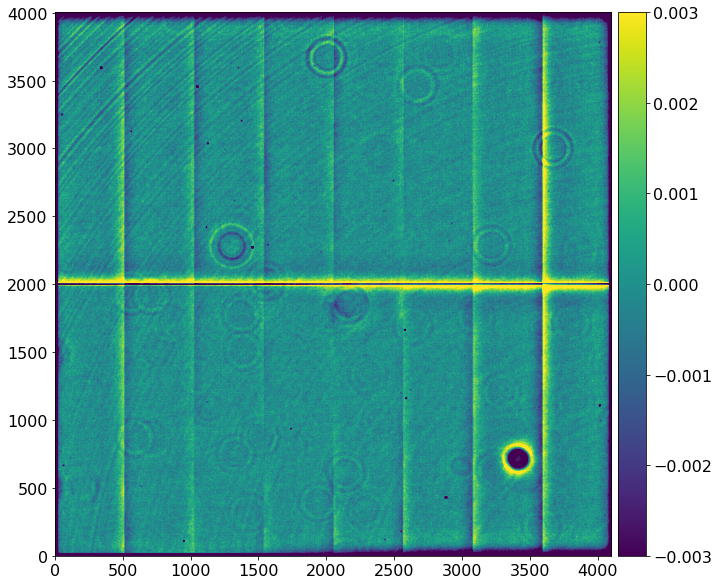

In [37]:
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
imshow(diff, interpolation='bicubic',vmin=-0.003,vmax=0.003)
# plt.title('%s, detector %s' % (ref.run, ref.dataId['detector']))

In [38]:
sensor = 'e2v'
hdu[1].data = diff
hdu.writeto('tmp/%s_flat_diff.fits'%(sensor),overwrite=True)

## Pre-processing: smooth and masking

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

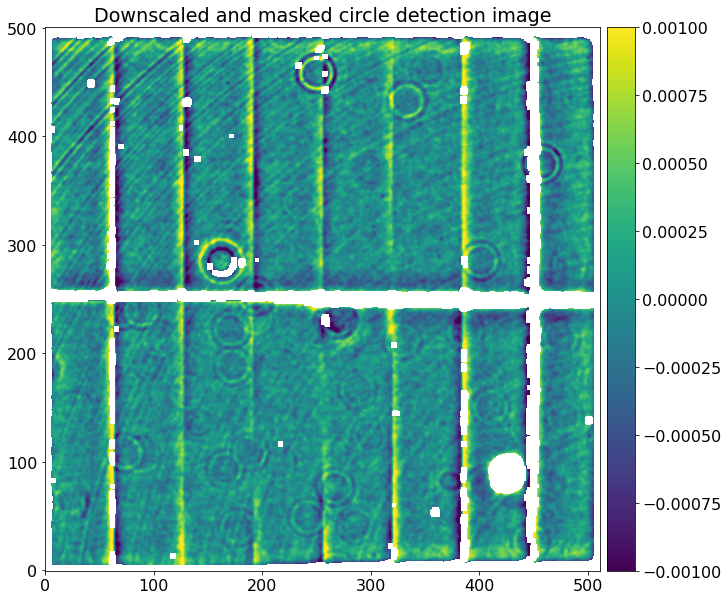

In [39]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.002 # For stronger rings
threshold = 0.0014 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask, (downscale, downscale), func=np.nanmax)
diff2[mask2] = None

imshow(diff2, interpolation='bicubic', vmin=-0.001, vmax=0.001)#
plt.title('Downscaled and masked circle detection image')

### Finding the TR Center

In [40]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x   = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

In [41]:
ylow, yhig = -1000., 0.
xlow, xhig = 4000., 5000.

cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]], popsize=40)
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.00019349033164114957
 message: 'Optimization terminated successfully.'
    nfev: 1123
     nit: 13
 success: True
       x: array([573.84826948, -75.68397193])

Original scale coordinates: 4590.79, -605.47


In [42]:
# x0, y0, std = 4627.47, -630.89, 0.00014681
# x0, y0 =4667, -678

### Diagnostic Plots

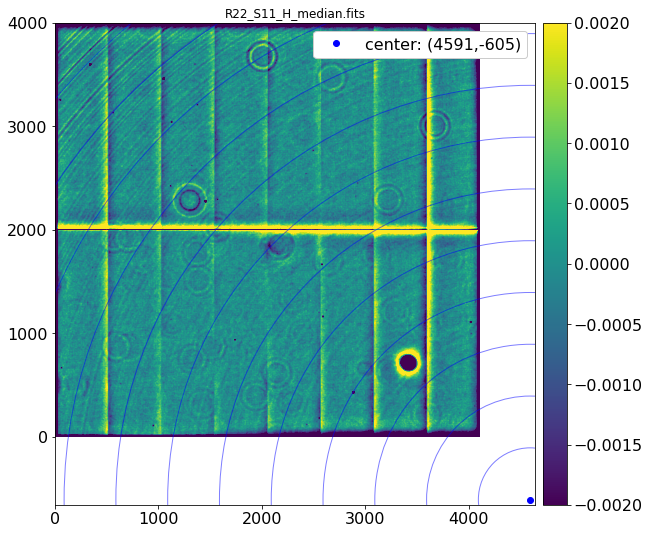

In [47]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, vmin=-0.002, vmax=0.002)
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 7000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

# plt.xlim(x0-50,4200)
# plt.ylim(-50,y0+50)

plt.ylim(y0-50,4000)
plt.xlim(0., x0+50)

plt.title('R22_S11_H_median.fits',fontsize=12)
# plt.show()

# Now make less restrictive mask
mask = np.abs(diff1) > 0.002
pos,v = fn_measure(x0, y0, mask=mask, step=1.0, statistic='mean')

# plt.subplot(211)
# plt.subplot2grid((4,1),(3,0), rowspan=1)

# plt.plot(pos, v, '-')
# plt.axhline(0, color='black', alpha=0.3, ls='--')
# plt.xlabel('Radius, pixels')
# plt.ylabel('Relative deviation')
# # plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
# plt.ylim(-0.002, 0.002)
# plt.tight_layout()

(5100.0, 6714.609891088261)

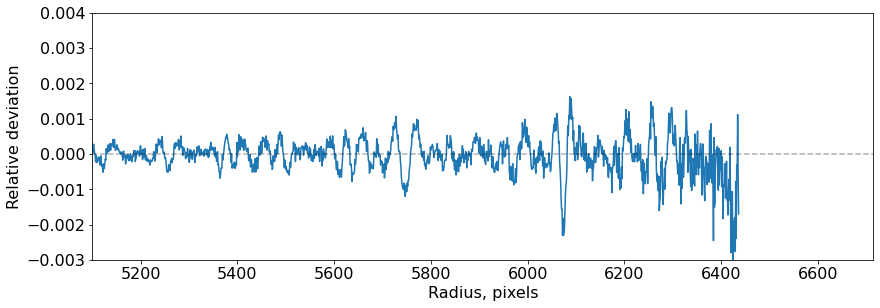

In [48]:
plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.003, 0.004)
plt.xlim(5100,)

Will analyse the following radial interval: 1979 - 6213 pixels


<ipython-input-49-42fb409ea4f5>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


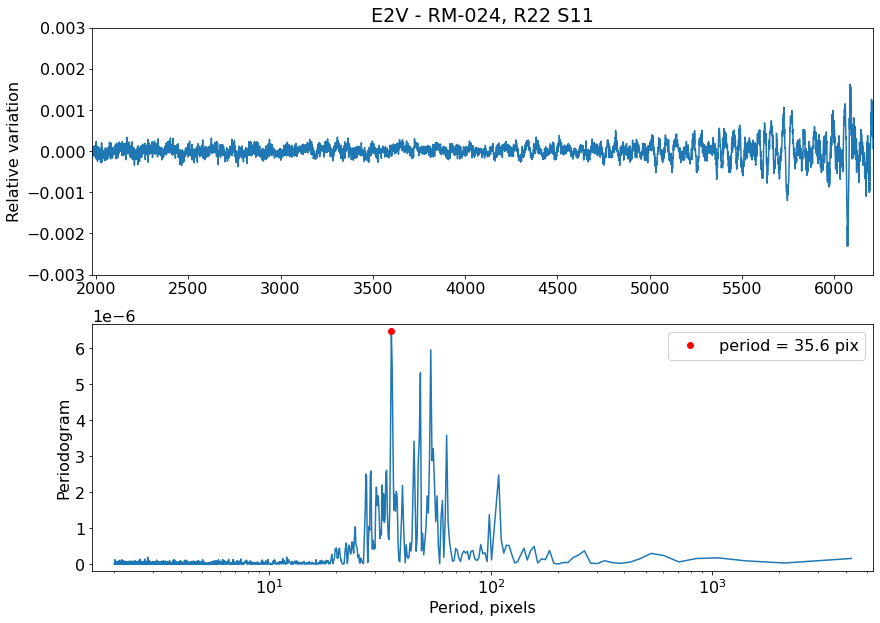

In [49]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
plt.ylim(-0.003, 0.003)
plt.title('E2V - RM-024, R22 S11')

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

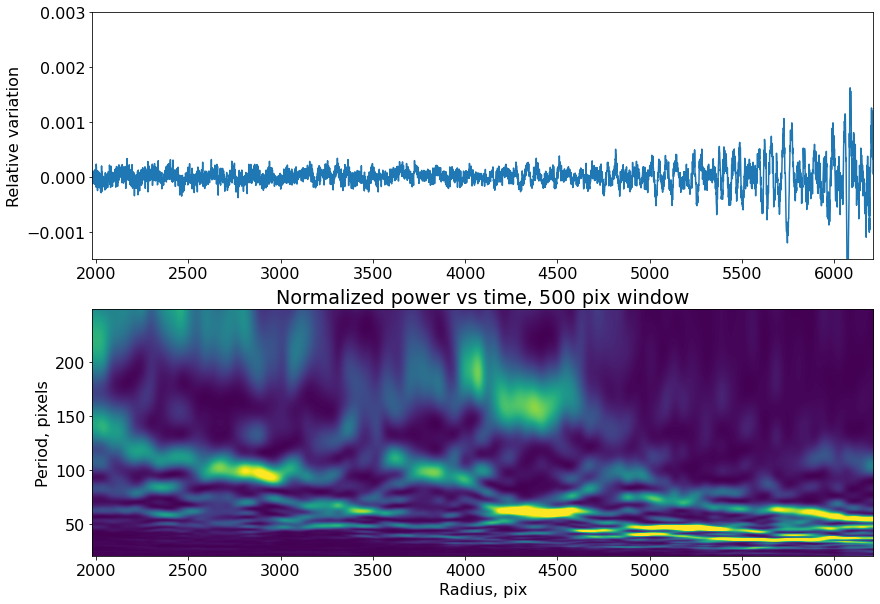

In [50]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


<ipython-input-51-57fd0f3833f5>:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


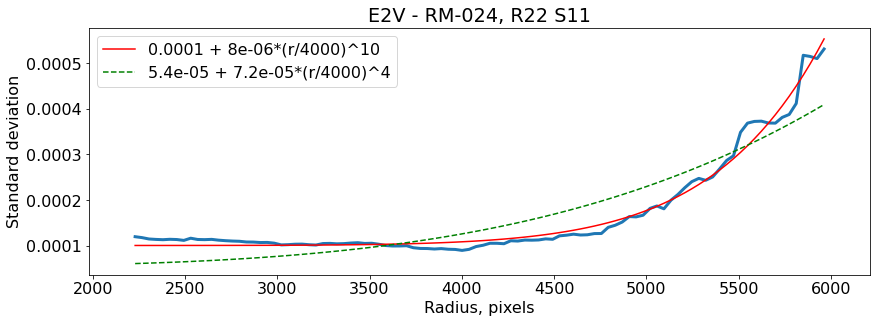

In [51]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title('E2V - RM-024, R22 S11')

#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)